## Initial data Preprocessing

I have first downloaded the entire dataset and sent all the images to a single folder along side creating a .csv file which contains the path of each image along with the name of the flower the image belongs to as well as the label given to ech flower category.

In [1]:
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import PReLU, LeakyReLU

## IGNORE THE WARNING

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Image loading and storing as array

In [2]:
def image_to_tensor(img_path):
    img = keras_image.load_img(r"/kaggle/input/flower-recog-cnn/flower" + img_path, target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

### Image to tensor

In [3]:
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True 
# Load the data
data = pd.read_csv('/kaggle/input/flow-csv/Untitled spreadsheet - Sheet1.csv')
files = data['file']
targets = data['label'].values
tensors = data_to_tensor(files);

# The bar graph below shows the loading of images as tensors and storing in form of an array

100%|██████████| 4317/4317 [00:20<00:00, 209.66it/s]


In [5]:
data.head()

,file,label,name
0,/100080576_f52e8ee070_n.jpg,0,daisy
1,/10043234166_e6dd915111_n.jpg,1,dandelion
2,/1008566138_6927679c8a.jpg,3,sunflower
3,/10090824183_d02c613f10_m.jpg,2,rose
4,/100930342_92e8746431_n.jpg,4,tulip


In [6]:
tensors.shape

(4317, 128, 128, 3)

In [7]:
names = ['Daisy','Dandelions','Rose','Sunflower','Tulip']

## Displaying the image

In [8]:
def display_images(img_path, ax):
    img = cv2.imread(r"/kaggle/input/flower-recog-cnn/flower" + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

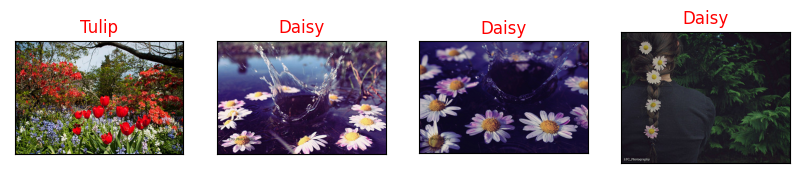

In [9]:
fig = plt.figure(figsize=(10,10)) # 10 x 10 inches
for i in range(4): # Only 4 images
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[]) # 2 rows and 4 columns and i+1 define sthe position ticks are markings along axes
    ax.set_title(names[targets[i+10]], color='r') # Title to the plot
    display_images(files[i+10], ax)

## Normalize the tensors
As pixel values can having varying intensity, so in order to bring each pixel value within the range of 0-1 we divide each pixel by 255(on a grayscale all intensities are between 0-255)

In [10]:
tensors = tensors.astype('float32')/255

## One-hot encoding

In [11]:
targets = to_categorical(targets, 5) 

## Split the data
80% - training set | 10% - testing set | 10% - validation set

In [12]:
x_train, x_test, y_train, y_test = train_test_split(tensors, targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
# Splitting the testing set to validationa and testing set into half
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [13]:
x_train.shape, y_train.shape

((3453, 128, 128, 3), (3453, 5))

In [14]:
x_test.shape, y_test.shape

((432, 128, 128, 3), (432, 5))

In [15]:
 x_valid.shape, y_valid.shape

((432, 128, 128, 3), (432, 5))

Label:  Tulip


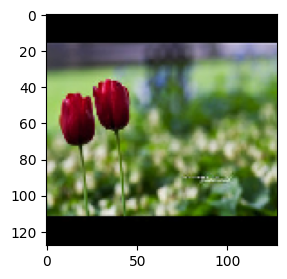

In [16]:
# Read and display a tensor
print('Label: ', names[np.argmax(y_train[7])])
plt.figure(figsize=(3,3))
plt.imshow((x_train[7]))

## CNN Model

In [17]:
def model():
    model = Sequential() # Initialise the empty sequential model 

    model.add(Conv2D(128, (3, 3), input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    # FINAL LAYER FOR CLASSIFICATION

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 

    model.add(Dense(5)) # Output layer
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model()

## Callbacks

In [18]:
# To save the best model
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5',verbose=2, save_best_only=True)

# Earlystopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

# To reduce learning rate dynamically
lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=5, verbose=2, factor=0.2)    


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 61, 61, 128)       0         
                                                        

## Training the model

In [20]:
history = model.fit(x_train, y_train, 
                    epochs=75, batch_size=32, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer, lr_reduction ,early_stop])

Epoch 1/75


2023-05-17 01:57:56.539018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 1.10360, saving model to weights.best.model.hdf5
108/108 - 12s - loss: 1.3210 - accuracy: 0.4243 - val_loss: 1.1036 - val_accuracy: 0.5255 - lr: 0.0010 - 12s/epoch - 116ms/step
Epoch 2/75

Epoch 2: val_loss improved from 1.10360 to 0.95211, saving model to weights.best.model.hdf5
108/108 - 5s - loss: 1.0151 - accuracy: 0.5948 - val_loss: 0.9521 - val_accuracy: 0.6366 - lr: 0.0010 - 5s/epoch - 43ms/step
Epoch 3/75

Epoch 3: val_loss improved from 0.95211 to 0.89084, saving model to weights.best.model.hdf5
108/108 - 5s - loss: 0.9163 - accuracy: 0.6383 - val_loss: 0.8908 - val_accuracy: 0.6505 - lr: 0.0010 - 5s/epoch - 44ms/step
Epoch 4/75

Epoch 4: val_loss improved from 0.89084 to 0.82825, saving model to weights.best.model.hdf5
108/108 - 5s - loss: 0.8386 - accuracy: 0.6704 - val_loss: 0.8283 - val_accuracy: 0.6898 - lr: 0.0010 - 5s/epoch - 44ms/step
Epoch 5/75

Epoch 5: val_loss improved from 0.82825 to 0.78150, saving model to weights.best.mod

In [21]:
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')

## Evaluation

In [22]:
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

14/14 [==============================] - 0s 13ms/step - loss: 0.5758 - accuracy: 0.7894


[0.5757853984832764, 0.7893518805503845]

In [23]:
# Calculate classification accuracy on the validation set
score = model.evaluate(x_valid, y_valid)
score

14/14 [==============================] - 0s 12ms/step - loss: 0.5892 - accuracy: 0.7940


[0.589205801486969, 0.7939814925193787]

In [24]:
# Calculate classification accuracy on the training set
score = model.evaluate(x_train, y_train)
score

108/108 [==============================] - 1s 12ms/step - loss: 0.3443 - accuracy: 0.9012


[0.3442569375038147, 0.9012452960014343]

## Plots

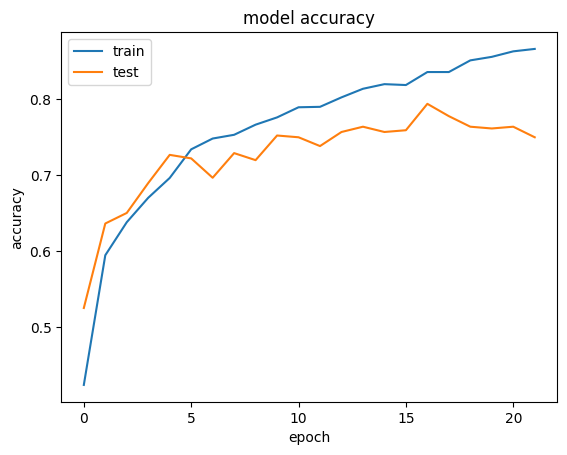

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

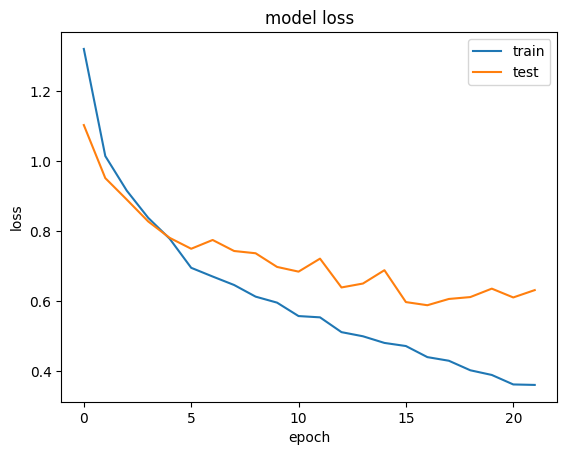

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [27]:
model.save('model.h5')

In [28]:
model1 = load_model('model.h5')

In [29]:
# Model predictions for the testing dataset
y_test_predict = model1.predict(x_test)

14/14 [==============================] - 0s 9ms/step


In [30]:
y_test_predict = np.argmax(y_test_predict,axis=1)

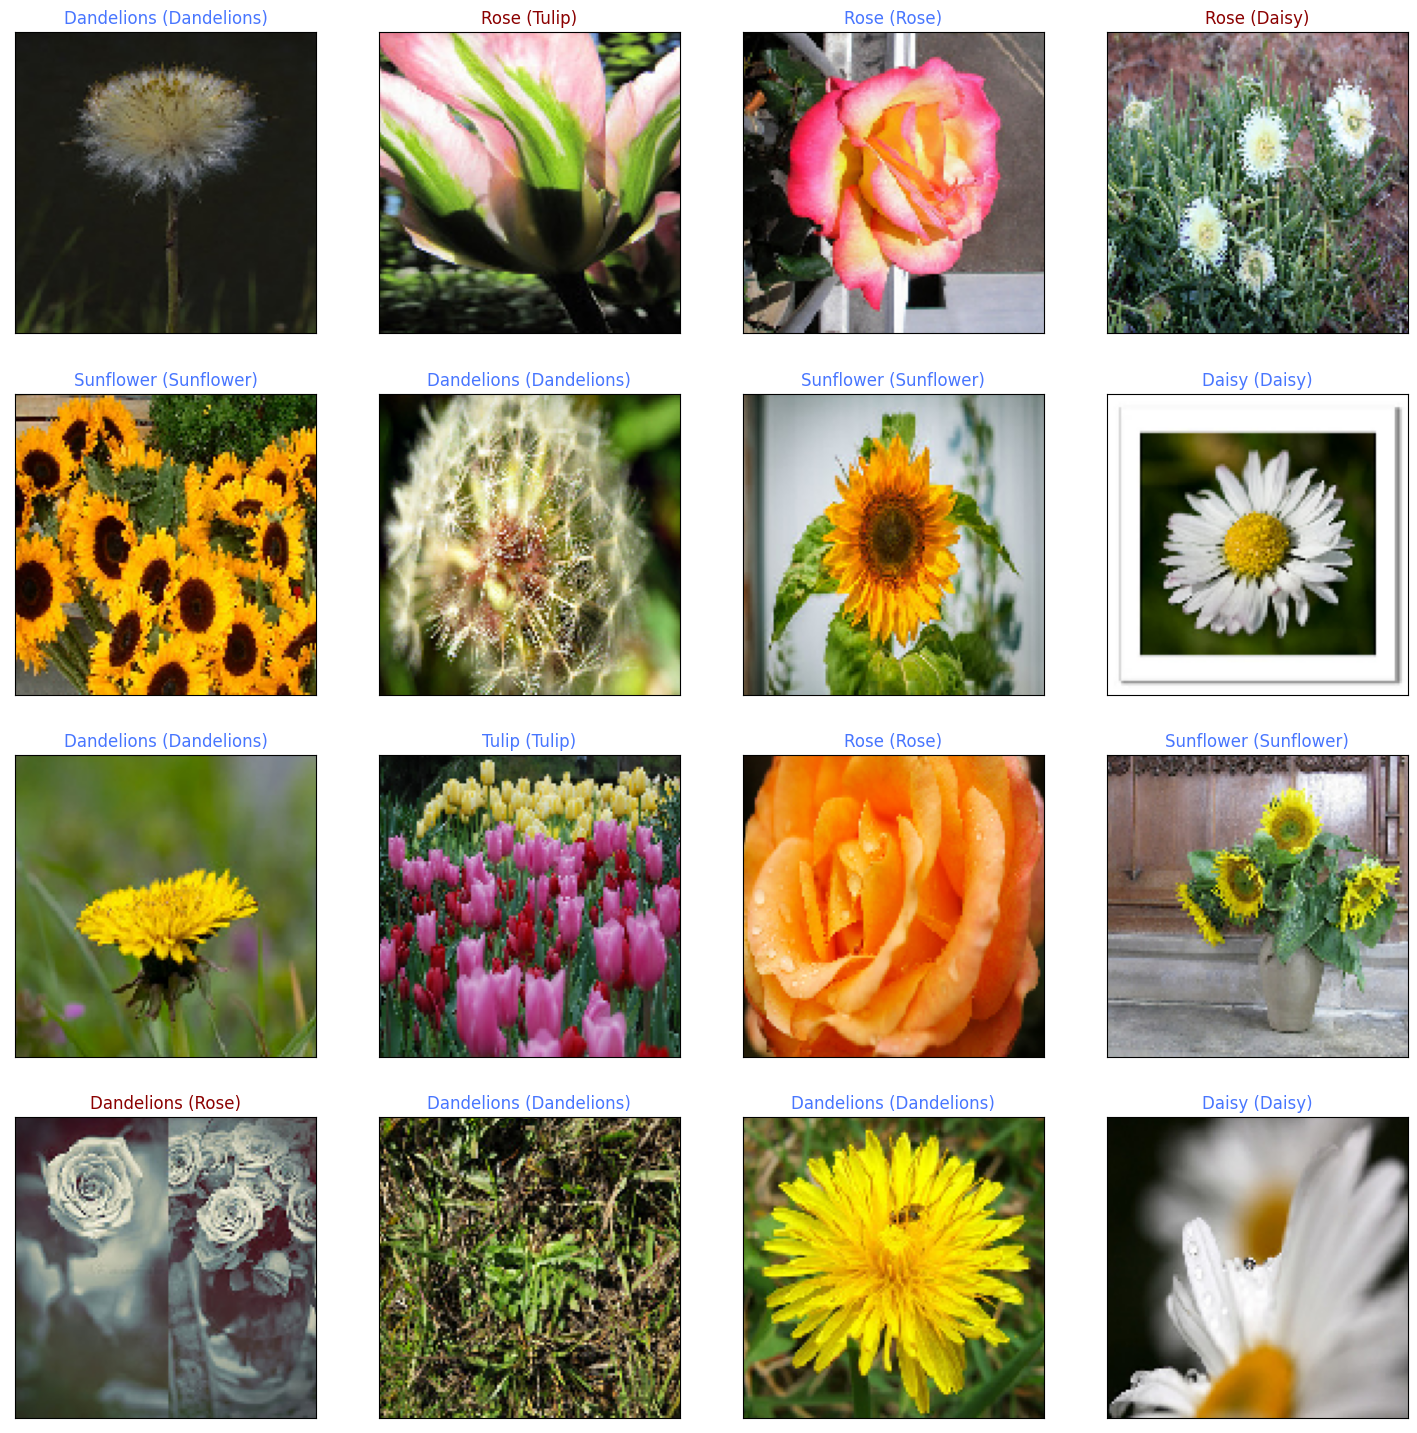

In [31]:
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))